In [6]:

# Updated imports for new LLMs and libraries
import warnings
import os

warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
 )

# API setup for LLMs (Groq, dotenv)
from groq import Groq
from dotenv import load_dotenv

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if GROQ_API_KEY:
    groq_client = Groq(api_key=GROQ_API_KEY)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

print("✓ Updated setup complete for new LLM sentiment analysis")

✓ Updated setup complete for new LLM sentiment analysis


## 1. Load Dataset

In [7]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
sentiments = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                sentiments.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_sentiment": sentiments})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nSentiment distribution:")
print(df["true_sentiment"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Sentiment distribution:
true_sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_sentiment
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Chain-of-Thought Prompt Design

**Prompt Strategy**: Stepwise reasoning with explicit JSON output format.

In [8]:
def create_cot_prompt(sentence):
    """
    Creates a Chain-of-Thought prompt for sentiment classification.
    Guides the model through stepwise reasoning.
    """
    prompt = f"""You are a financial sentiment analysis expert. Analyze the following financial statement step-by-step.

Classify the sentiment of the following financial statement as either "positive", "negative", or "neutral" from an investor's perspective.

Think through this systematically:
Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
Step 2: List any positive signals (growth, profit increases, expansions, etc.).
Step 3: List any negative signals (losses, declines, challenges, etc.).
Step 4: Evaluate the net impact on stock price from an investor's perspective.
Step 5: Based on your analysis, classify the sentiment.

Classification guidelines:
- Positive: Good news for stock price (revenue increase, profit growth, etc.)
- Negative: Bad news for stock price (losses, declining sales, etc.)
- Neutral: No clear impact on stock price or mixed signals

IMPORTANT: Provide your final answer in this exact JSON format:
{{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Brief summary of your step-by-step reasoning"
}}

Financial Statement: "{sentence}"
"""
    
    return prompt

## 3. Model Inference Functions

In [9]:
def call_llama(prompt, model_name, temperature=0.0):
    """Call Llama via Groq API"""
    max_retries = 3
    last_error = None
    for attempt in range(max_retries):
        try:
            chat_completion = groq_client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=model_name,
                temperature=temperature,
                max_tokens=500,
            )
            return chat_completion.choices[0].message.content
        except Exception as e:
            last_error = str(e)
            print(f"Attempt {attempt + 1}/{max_retries} failed: {last_error}")
            if attempt < max_retries - 1:
                time.sleep(2**attempt)
                continue
            return None
    return None

def parse_response(response_text):
    """Parse JSON response from model"""
    try:
        # Try to extract JSON from response
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            json_str = response_text.strip()
        result = json.loads(json_str)
        return result
    except Exception as e:
        print("Parse error: {}".format(str(e)[:100]))
        print("Raw response was:\n{}".format(response_text))
        # Fallback: try to extract sentiment with regex
        response_lower = response_text.lower() if response_text else ""
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "sentiment": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "negative" in response_lower:
            return {
                "sentiment": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "neutral" in response_lower:
            return {
                "sentiment": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        return None

print("✓ Model inference functions defined")

✓ Model inference functions defined


## 4. Run Experiments

In [10]:
# Updated experiment runs for new LLMs
test_df = df.head(100).copy()  # Use a sample of the dataset

# E7: Updated GPT OSS 20B (Chain-of-Thought)
print("Running E7: Updated GPT OSS 20B (Chain-of-Thought)...")
e7_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E7 Progress"):
    prompt = create_cot_prompt(row["sentence"])
    response = call_llama(prompt, model_name="openai/gpt-oss-20b")
    if response:
        parsed = parse_response(response)
        if parsed:
            e7_results.append({
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": parsed.get("sentiment", "unknown"),
                "confidence": parsed.get("confidence", 0),
                "rationale": parsed.get("rationale", ""),
            })
        else:
            e7_results.append({
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": "error",
                "confidence": 0,
                "rationale": "Parse error",
            })
    time.sleep(0.5)
e7_df = pd.DataFrame(e7_results)
print(f"\n✓ E7 completed: {len(e7_df)} predictions")
display(e7_df.head())

# E8: Updated GPT OSS 1Z20B (Chain-of-Thought)
print("Running E8: Updated GPT OSS 120B (Chain-of-Thought)...")
e8_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E8 Progress"):
    prompt = create_cot_prompt(row["sentence"])
    response = call_llama(prompt, model_name="openai/gpt-oss-120b")
    if response:
        parsed = parse_response(response)
        if parsed:
            e8_results.append({
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": parsed.get("sentiment", "unknown"),
                "confidence": parsed.get("confidence", 0),
                "rationale": parsed.get("rationale", ""),
            })
        else:
            e8_results.append({
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": "error",
                "confidence": 0,
                "rationale": "Parse error",
            })
    time.sleep(0.5)
e8_df = pd.DataFrame(e8_results)
print(f"\n✓ E8 completed: {len(e8_df)} predictions")
display(e8_df.head())

# E9: Updated Llama-3.3-70B (Chain-of-Thought)
print("Running E9: Updated Llama-3.3-70B (Chain-of-Thought)...")
e9_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E9 Progress"):
    prompt = create_cot_prompt(row["sentence"])
    response = call_llama(prompt, model_name="llama-3.3-70b-versatile")
    if response:
        parsed = parse_response(response)
        if parsed:
            e9_results.append({
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": parsed.get("sentiment", "unknown"),
                "confidence": parsed.get("confidence", 0),
                "rationale": parsed.get("rationale", ""),
            })
        else:
            e9_results.append({
                "sentence": row["sentence"],
                "true_sentiment": row["true_sentiment"],
                "predicted_sentiment": "error",
                "confidence": 0,
                "rationale": "Parse error",
            })
    time.sleep(0.5)
e9_df = pd.DataFrame(e9_results)
print(f"\n✓ E9 completed: {len(e9_df)} predictions")
display(e9_df.head())

Running E7: Updated GPT OSS 20B (Chain-of-Thought)...


E7 Progress: 100%|██████████| 100/100 [04:56<00:00,  2.96s/it]


✓ E7 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,positive,0.70,The statement highlights that the company is e...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Step 1: Key metrics are net sales (EUR131m vs ...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,The statement reports a 5.2% increase in net s...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased from EUR 8.7 mn to ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit rose from EUR 18.6 mn in 2007...


Running E8: Updated GPT OSS 120B (Chain-of-Thought)...


E8 Progress: 100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


✓ E8 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.62,Step 1: The statement mentions growth in Russi...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.96,Step 1: The statement reports net sales and pr...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.96,Step 1: The statement reports Q3 2010 net sale...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Step 1: The statement reports operating profit...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.92,Step 1: The statement reports operating profit...


Running E9: Updated Llama-3.3-70B (Chain-of-Thought)...


E9 Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's break it down step by step:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The statement mentions the company's growth and its plans regarding production locations, specifically considering Russia as a place of growth.

Step 2: List any positive signals.
- The company is growing, which is a positive signal.
- The consideration of Russia as a place for growth might indicate expanding markets or opportunities.

Step 3: List any negative signals.
- There are no explicit negative signals mentioned in the statement, such as losses, declines, or challenges.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The growth of the company is generally good news for investors, as it can lead to increased revenue and profitability.
- The fact that the company has no plans to move all 

E9 Progress:   1%|          | 1/100 [00:01<03:01,  1.83s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are net sales and pre-tax profit for the last quarter of 2010 compared to the same period in the previous year.

Step 2: List any positive signals.
- Net sales doubled from EUR76m to EUR131m.
- The company moved to a zero pre-tax profit from a pre-tax loss of EUR7m, indicating an improvement in profitability.

Step 3: List any negative signals.
- There are no direct negative signals mentioned in the statement. The movement from a loss to breaking even (zero pre-tax profit) could be seen as a neutral or slightly positive development, depending on expectations for profit growth.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The doubling of net sales is a strong positive

E9 Progress:   2%|▏         | 2/100 [00:03<03:00,  1.84s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are net sales and operating profit for the third quarter of 2010.
- Net sales increased to EUR 205.5 mn.
- Operating profit increased to EUR 23.5 mn.

Step 2: List any positive signals.
- Net sales increased by 5.2%.
- Operating profit increased by 34.9%.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in net sales and significant increase in operating profit are both positive indicators for the company's financial health and performance.
- These increases are likely to have a positive impact on the stock price, as they indicate growth and profitability.

Step 5:

E9 Progress:   3%|▎         | 3/100 [00:05<02:40,  1.65s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit, which has increased from EUR 8.7 million to EUR 13.1 million.
- Another key metric is the percentage of net sales that the operating profit represents, which is 7.7%.

Step 2: List any positive signals.
- The operating profit has increased from EUR 8.7 million to EUR 13.1 million, which is a positive signal indicating growth and improvement in profitability.
- The operating profit as a percentage of net sales is 7.7%, which suggests a healthy margin.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in operating profit and th

E9 Progress:   4%|▍         | 4/100 [00:06<02:42,  1.69s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit, which totalled EUR 21.1 million.
- Another key metric is the comparison to the previous year (2007), where the operating profit was EUR 18.6 million.
- The operating profit as a percentage of net sales is also mentioned, at 9.7%.

Step 2: List any positive signals.
- The operating profit has increased from EUR 18.6 million to EUR 21.1 million, which is a positive signal.
- The increase represents a growth, which is typically viewed favorably by investors.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement. The comparison is entirely favorable, with an increase in operating profit.

Step 4: Evaluate the net impact on stock pric

E9 Progress:   5%|▌         | 5/100 [00:08<02:42,  1.71s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are:
  - Operating profit for 2005: EUR 20.5 million
  - Operating profit for 2004: EUR 9.3 million
  - Net sales for 2005: EUR 103.3 million
  - Net sales for 2004: EUR 96.4 million

Step 2: List any positive signals.
- Operating profit increased from EUR 9.3 million in 2004 to EUR 20.5 million in 2005, which is more than a 100% increase.
- Net sales increased from EUR 96.4 million in 2004 to EUR 103.3 million in 2005, showing a growth in sales.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in operating profit and net sales suggests a positive performance of t

E9 Progress:   6%|▌         | 6/100 [00:10<02:38,  1.68s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are sales increase and operating profit rise.

Step 2: List any positive signals.
- Sales increased by 8% to EUR 155.2 million.
- Operating profit rose from EUR 17.1 million to EUR 31.1 million.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in sales and operating profit, the net impact is likely positive, as these are indicators of a company's financial health and potential for future growth.

Step 5: Based on your analysis, classify the sentiment.
- The sentiment is positive because the statement reports growth in sales and an increase in operating profi

E9 Progress:   7%|▋         | 7/100 [00:11<02:26,  1.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are consolidated net sales and operating profit.
- The specific figures are: 
  - Consolidated net sales increased by 16% to EUR 74.8 million.
  - Operating profit is EUR 0.9 million, compared to a loss of EUR 0.7 million in the prior year.

Step 2: List any positive signals.
- The 16% increase in consolidated net sales is a positive signal, indicating growth in sales.
- The transition from a loss of EUR 0.7 million to an operating profit of EUR 0.9 million is also a positive signal, showing improvement in profitability.

Step 3: List any negative signals.
- There are no explicitly negative signals mentioned in the statement. The comparison is entirely favorable, with both an increase in sales and a mov

E9 Progress:   8%|▊         | 8/100 [00:13<02:28,  1.61s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics are the sales increases in the Foundries division and the Machine Shop division, with specific percentages and euro amounts provided for each.

Step 2: List any positive signals.
- The Foundries division reports a 9.7% increase in sales to EUR 63.1 mn from EUR 57.5 mn.
- The Machine Shop division reports a 16.4% increase in sales to EUR 41.2 mn from EUR 35.4 mn.
Both of these are positive signals as they indicate growth in sales.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement. No declines, losses, or challenges are reported.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the positive growth in sales in both divisions, this ne

E9 Progress:   9%|▉         | 9/100 [00:14<02:25,  1.60s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's break it down step by step:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key events mentioned are Nokia's plans to team up with Sanyo to manufacture 3G handsets and Nokian Tyres' fourth-quarter earnings report beating analysts' expectations.

Step 2: List any positive signals.
- Nokia's partnership with Sanyo for 3G handsets can be seen as a positive signal, indicating potential for growth and expansion into new markets or technologies.
- Nokian Tyres' earnings beating analysts' expectations is a positive signal, indicating the company's strong performance.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the positive news about Nokia and Nokian Tyres, the net im

E9 Progress:  10%|█         | 10/100 [00:16<02:27,  1.64s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the dividend per share.
- The dividend for 2010 is proposed to be EUR0.12 per share.
- The dividend for 2009 was EUR0.08 per share.

Step 2: List any positive signals.
- The dividend per share for 2010 is increased from EUR0.08 to EUR0.12, which is a 50% increase.
- This increase suggests that the company is performing well financially and can afford to distribute more profits to its shareholders.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- An increase in dividend payout is generally viewed positively by investors because it indicates the company's financial health and 

E9 Progress:  11%|█         | 11/100 [00:18<02:25,  1.64s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are the increase in MegaFon's subscriber base (16.1% increase to 50.5 million users) and the increase in market share (from 23% to 24%).

Step 2: List any positive signals.
- The subscriber base increased by 16.1%, indicating growth.
- The market share increased from 23% to 24%, showing expansion.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the growth in the subscriber base and the increase in market share, this news is likely to have a positive impact on the stock price, as it indicates the company is performing well and expanding its customer base.

Step 5: Based 

E9 Progress:  12%|█▏        | 12/100 [00:19<02:18,  1.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics are net income from life insurance and net income from non-life insurance, with specific figures provided for the current period and the corresponding period in 2009.

Step 2: List any positive signals.
- Net income from life insurance doubled from EUR 3.2 mn to EUR 6.8 mn.
- Net income from non-life insurance significantly increased from EUR 1.5 mn to EUR 5.2 mn.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increases in net income from both life and non-life insurance, this would likely have a positive impact on the stock price, as it indicates strong financia

E9 Progress:  13%|█▎        | 13/100 [00:21<02:14,  1.54s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are net sales and pretax profit, along with their respective changes.

Step 2: List any positive signals.
- Net sales have increased from EUR179.9m to EUR193.3m.
- Pretax profit has risen by 34.2% to EUR43.1m.
Both of these are positive signals indicating growth in sales and profitability.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net sales and the significant rise in pretax profit, the net impact is likely to be positive. Investors typically view revenue growth and profit increases as favorable indicators of a company's health and potential for fu

E9 Progress:  14%|█▍        | 14/100 [00:22<02:11,  1.53s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the increase in net sales by 18.5% to EUR 167.8 million.
- Another key point is that EUR 20.4 million (or 12.2%) of the sales came from acquisitions made in 2009.

Step 2: List any positive signals.
- The net sales surged by 18.5%, which is a significant increase.
- The contribution of EUR 20.4 million from the 2009 acquisitions indicates successful integration and revenue generation from these investments.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in net sales and the successful contribution from recent acquisitions are likely to have a positive impact o

E9 Progress:  15%|█▌        | 15/100 [00:24<02:12,  1.56s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are the operating profit and total revenue of Nordea Group for the year 2010.
- Operating profit increased by 18% year-on-year to 3.64 billion euros.
- Total revenue increased by 3% to 9.33 billion euros.

Step 2: List any positive signals.
- Operating profit increased by 18%, which is a significant growth indicator.
- Total revenue also increased, albeit by a smaller percentage, still indicating growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement regarding losses, declines, or challenges.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in operating profit and total revenue, this news is likely to hav

E9 Progress:  16%|█▌        | 16/100 [00:25<02:09,  1.54s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a nine-month period compared to the corresponding period in 2005.

Step 2: List any positive signals.
- Operating profit increased from EUR13.6m.
- Net sales increased from EUR394.7m.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this is likely to have a positive impact on the stock price, as it indicates the company is performing well financially.

Step 5: Based on your analysis, classify the sentiment.
- Since there are increases in both operating profit and net sales wit

E9 Progress:  17%|█▋        | 17/100 [00:27<02:03,  1.49s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

### Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- Operating profit for the three-month period increased from EUR1.2m.
- Revenue increased from EUR20.2m.
- The comparison is made with the corresponding period in 2005.

### Step 2: List any positive signals.
- Increase in operating profit.
- Increase in revenue.

### Step 3: List any negative signals.
- None mentioned in the statement.

### Step 4: Evaluate the net impact on stock price from an investor's perspective.
Given the increases in both operating profit and revenue, this typically signals a positive performance of the company. Such increases are usually viewed favorably by investors as they indicate growth and potential for further financial success.

### Step 5: Based on your analysis, classify the sentiment.
Since 

E9 Progress:  18%|█▊        | 18/100 [00:28<02:08,  1.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are net profit and sales. Specifically, the net profit is 82.2 million euros, and sales are 686.5 million euros for 2005.

Step 2: List any positive signals.
- Net profit increased by 11.4% compared to the previous year.
- Sales increased by 13.8% compared to the previous year.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increases in both net profit and sales, this news is likely to have a positive impact on the stock price, as it indicates the company is performing well and growing.

Step 5: Based on your analysis, classify the sentiment.
- Since both key metri

E9 Progress:  19%|█▉        | 19/100 [00:30<02:03,  1.53s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the volume of the Lithuanian beer market, which was 14.41 million liters in January.
- There's a comparison to the year-earlier figure, showing a rise of 0.8 percent.

Step 2: List any positive signals.
- The rise of 0.8 percent in the beer market volume compared to the year-earlier figure is a positive signal, indicating growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement, such as declines, losses, or challenges.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the positive signal of a 0.8 percent rise in the market volume, this could be seen as good news for companies operating within the Lithuanian beer market

E9 Progress:  20%|██        | 20/100 [00:31<02:05,  1.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are cargo revenue and cargo volume, with specific increases in both areas.

Step 2: List any positive signals.
- Cargo revenue increased by 5.4% to EUR 21.46 million.
- Cargo volume increased by 2.4% to 70,116 cargo units.
Both of these are positive signals as they indicate growth in the company's cargo operations.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increases in cargo revenue and volume, this news is likely to have a positive impact on the stock price, as it suggests the company is performing well and growing its business.

Step 5: Based on the analysis

E9 Progress:  21%|██        | 21/100 [00:33<02:00,  1.52s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the fair value of the property portfolio, which has doubled.
- The total value of the property portfolio is given as EUR 2,686.2 million, with a comparison to a previous value of EUR 1,259.7 million.

Step 2: List any positive signals.
- The fair value of the property portfolio has doubled, indicating significant growth.
- The acquisition of Kapiteeli is implied to be a positive event, contributing to this growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The doubling of the property portfolio's fair value is likely to be seen as a positive indicator of the company's 

E9 Progress:  22%|██▏       | 22/100 [00:34<01:56,  1.49s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are the net profit for 2010 and 2009, and the proposal for a raised payout.
- Specific numbers are: 2010 net profit = EUR297.3m, 2009 net profit = EUR107.1m.

Step 2: List any positive signals.
- The net profit almost tripled from 2009 to 2010, which is a significant increase.
- The company announced a proposal for a raised payout, which suggests confidence in future financial performance and a willingness to reward shareholders.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The significant increase in net profit and the proposal for a raised payout are both positive indica

E9 Progress:  23%|██▎       | 23/100 [00:36<01:58,  1.54s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the Earnings Per Share (EPS) for the years 2008 and 2009.

Step 2: List any positive signals.
- The EPS increased from EUR1.12 in 2008 to EUR1.13 in 2009, indicating a growth in earnings per share.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that the EPS has increased, this is generally considered good news for investors as it indicates the company's profitability is improving. An increase in EPS can lead to an increase in the stock price, as higher earnings per share often reflect positively on a company's financial health and potential for future growt

E9 Progress:  24%|██▍       | 24/100 [00:37<01:55,  1.51s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are commission income and lending volume, with specific percentage increases.

Step 2: List any positive signals.
- Commission income increased by 22%.
- Lending volume rose by 13.5%.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increases in commission income and lending volume, this would likely be viewed as positive for the company's financial health and performance, suggesting a potential increase in stock price.

Step 5: Based on your analysis, classify the sentiment.
- Since both mentioned metrics show significant increases without any negative signals, the 

E9 Progress:  25%|██▌       | 25/100 [00:39<01:48,  1.45s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are:
  - Revenue Passenger Kilometres (RPK), which measures traffic and went up by 3.2%.
  - Available Seat Kilometres (ASK), which measures capacity and rose by 12.2%.

Step 2: List any positive signals.
- Positive signals include:
  - An increase in RPK by 3.2%, indicating growth in traffic.
  - An increase in ASK by 12.2%, suggesting expansion in capacity.

Step 3: List any negative signals.
- There are no direct negative signals mentioned in the statement, such as losses or declines. However, the increase in capacity (ASK) outpacing the increase in traffic (RPK) could potentially lead to a decrease in load factor, which might be seen as a negative signal. But this is not explicitly stated as a negat

E9 Progress:  26%|██▌       | 26/100 [00:41<01:59,  1.61s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are net profit and net sales for the period of January-September 2010, compared to the same period in the previous year.

Step 2: List any positive signals.
- Net profit increased by 14% year-on-year.
- Net sales increased from EUR 487.7 million to EUR 525.3 million.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in net profit and net sales is likely to have a positive impact on the stock price, as it indicates the company's financial health and growth.

Step 5: Based on your analysis, classify the sentiment.
- Given the positive signals (increase in net profit 

E9 Progress:  27%|██▋       | 27/100 [00:42<01:55,  1.58s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics are net income from life insurance and net income from non-life insurance, with comparisons to the previous year (2009).

Step 2: List any positive signals.
- Net income from life insurance increased from EUR 14.0 mn to EUR 16.5 mn.
- Net income from non-life insurance increased from EUR 15.2 mn to EUR 22.6 mn.
Both of these increases are positive signals as they indicate growth in income from both life and non-life insurance sectors.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement. The focus is entirely on the increase in net income from both sectors.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increases in net income 

E9 Progress:  28%|██▊       | 28/100 [00:44<01:56,  1.62s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's break it down step by step:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is "sales," specifically in the context of "other export markets."

Step 2: List any positive signals.
- The statement mentions that "sales have risen," which is a positive signal indicating growth in revenue from export markets.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that sales have risen, this typically indicates a positive trend for a company's revenue and potentially its profitability, which can lead to an increase in stock price.

Step 5: Based on your analysis, classify the sentiment.
- Since the statement reports an increase in sales without mentioning a

E9 Progress:  29%|██▉       | 29/100 [00:45<01:51,  1.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is "Sales," and the events or indicators are "growing market rates" and "increased operations."

Step 2: List any positive signals.
- Sales increased: This is a direct positive signal as it indicates revenue growth.
- Growing market rates: This suggests a favorable market condition that could continue to support sales growth.
- Increased operations: This implies expansion or scaling up of business activities, which can lead to further growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in sales due to both external (growing market rates) and internal (in

E9 Progress:  30%|███       | 30/100 [00:47<01:55,  1.65s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's break it down step by step:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key event mentioned is the strengthening of a long-term partnership with Nokia Siemens Networks.

Step 2: List any positive signals.
- The statement implies a positive development by mentioning the strengthening of a partnership, which can lead to future collaborations, increased business opportunities, and potentially more stable or increased revenue streams.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- From an investor's perspective, the strengthening of a long-term partnership can be seen as a positive sign, as it may lead to increased stability, potential for growth, and improved business 

E9 Progress:  31%|███       | 31/100 [00:51<02:31,  2.20s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The company's order book value: 1.5 billion euros ($2.2 billion) as of September 30, 2007.
- Increase in the order book: 24.2% year-over-year.
- International orders: 365 million euros ($534.3 million).

Step 2: List any positive signals.
- The order book has increased by 24.2% year-over-year, indicating growth.
- International orders contribute significantly to the total, suggesting global demand for the company's products or services.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in the order book and the significant contribution of international orders, this news is likely to have a positive impact on 

E9 Progress:  32%|███▏      | 32/100 [00:54<02:57,  2.62s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are the increase in paper demand across all main markets and a 4 percent increase in average paper prices compared to last year.

Step 2: List any positive signals.
- Increase in paper demand across all main markets.
- Average paper prices increased by 4 percent compared to last year.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in demand and the ability to raise prices, this typically suggests higher revenues and potentially higher profits, which are positive indicators for investors.

Step 5: Based on your analysis, classify the sentiment.
- Since there are positive signals (i

E9 Progress:  33%|███▎      | 33/100 [00:58<03:12,  2.88s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the net profit for the three-month period until Dec. 31, which surged to euro603 million (US$ 781 million), or euro3.33 (US$ 4.31) per share.

Step 2: List any positive signals.
- The net profit surged significantly from euro172 million to euro603 million.
- The profit per share increased substantially from euro0.94 to euro3.33 (or from US$ 4.31 per share, implying a significant increase).

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in net profit and profit per share, this news is likely to have a positive impact on the stock pri

E9 Progress:  34%|███▍      | 34/100 [01:01<03:25,  3.12s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are the percentage increases in share prices of Standard Chartered (STAN), Royal Bank of Scotland (RBS), and Barclays (BARC or BCS) within the FTSE 100 index.

Step 2: List any positive signals.
- Shares of Standard Chartered rose by 1.2%.
- Royal Bank of Scotland shares rose by 2%.
- Barclays shares were up by 1.7%.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increases in share prices of these major banking institutions indicate a positive performance, which is generally good news for investors.

Step 5: Based on your analysis, classify the sentiment.
- Given that al

E9 Progress:  35%|███▌      | 35/100 [01:05<03:33,  3.29s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's break it down step by step:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are the increase in Nokia Corp.'s third-quarter earnings and the increase in its share of the global handset market.

Step 2: List any positive signals.
- Earnings almost doubled.
- Share of the global handset market increased.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in earnings and market share is likely to have a positive impact on the stock price, as it indicates the company's financial health and competitiveness are improving.

Step 5: Based on the analysis, classify the sentiment.
- Given the positive signals (earnings increase, market share increase) and the absence of neg

E9 Progress:  36%|███▌      | 36/100 [01:09<03:32,  3.32s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are net profit and dividend per share.
- The net profit for 2010 is SEK6.745 billion, compared to SEK1.114 billion in the previous year.
- A 50% dividend increase to SEK1.50 per share is proposed.

Step 2: List any positive signals.
- Net profit has significantly increased from SEK1.114 billion to SEK6.745 billion.
- A 50% dividend increase is proposed, which indicates a return of value to shareholders.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The significant increase in net profit and the proposed dividend increase are both positive indicators for investors.
- These f

E9 Progress:  37%|███▋      | 37/100 [01:12<03:33,  3.40s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The statement mentions a future scenario for Finland's national economy, developed by a research manager using a model from the University of Denver.

Step 2: List any positive signals.
- There are no explicit positive signals mentioned in the statement, such as growth, profit increases, or expansions.

Step 3: List any negative signals.
- Similarly, there are no explicit negative signals mentioned, such as losses, declines, or challenges.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the lack of specific financial metrics or outcomes (positive or negative), it's challenging to determine a direct impact on stock price. The development of a future scenario could be seen as a neutral or in

E9 Progress:  38%|███▊      | 38/100 [01:16<03:34,  3.45s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key event mentioned is the subscription of shares with warrants and an increase in share capital.
- A total of 119,850 shares have been subscribed with the BasWare Warrant Program.

Step 2: List any positive signals.
- The subscription of a significant number of shares (119,850) indicates investor interest and confidence in the company.
- An increase in share capital can lead to more funds available for the company to invest in growth opportunities.

Step 3: List any negative signals.
- There are no explicit negative signals mentioned in the statement, such as losses, declines, or challenges.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in share capital and the subscription o

E9 Progress:  39%|███▉      | 39/100 [01:19<03:34,  3.51s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key event mentioned is the possibility of subscribing for up to 666,104 new shares by exercising B options under the 2004 stock option plan.

Step 2: List any positive signals.
- The ability to subscribe for new shares could indicate potential for growth or investment in the company.
- It suggests that the company has a plan in place for potential expansion or incentivizing employees, which could be seen as positive for long-term growth.

Step 3: List any negative signals.
- There are no direct negative signals mentioned in the statement, such as losses, declines, or challenges.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The announcement of potential new shares could have a neutral to slightly positive 

E9 Progress:  40%|████      | 40/100 [01:23<03:41,  3.70s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's break it down step by step:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The company, Tiimari, operates 194 stores.
- It is present in six countries, including its core Finnish market.
- The company generated a turnover of 76.5 million euros in 2005.

Step 2: List any positive signals.
- The presence of 194 stores across six countries indicates a significant market presence and potential for revenue.
- The mention of a "core Finnish market" suggests a strong foundation or base of operations.
- The generation of 76.5 million euros in turnover is a positive financial indicator, suggesting the company has a substantial revenue stream.

Step 3: List any negative signals.
- There are no explicit negative signals in the statement, such as losses, declines, or challenges.

Step 4: Evaluate the net impact o

E9 Progress:  41%|████      | 41/100 [01:25<03:02,  3.09s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key event mentioned is an acquisition.
- The key metrics or indicators are "increase in sales" and "market position" in the Russian metal industry coatings market.

Step 2: List any positive signals.
- The acquisition will "considerably increase" Kemira's sales.
- It will also increase Kemira's market position in the specified market.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in sales and improvement in market position, this news is likely to have a positive impact on the stock price, as it indicates potential for future growth and increased profitability.

Step 5: Based o

E9 Progress:  42%|████▏     | 42/100 [01:29<03:07,  3.23s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the net sales of Finnlines, which has increased from EUR 473.5 mn to EUR 505.4 mn.

Step 2: List any positive signals.
- The increase in net sales from EUR 473.5 mn to EUR 505.4 mn is a positive signal, indicating growth in revenue.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net sales, this would likely have a positive impact on the stock price, as revenue growth is typically seen as a favorable indicator of a company's performance and potential for future growth.

Step 5: Based on your analysis, classify the sentiment.
- Since the state

E9 Progress:  43%|████▎     | 43/100 [01:32<03:08,  3.31s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the increase in the Division's net sales by 1.7%, adjusted for changes in the Group structure.

Step 2: List any positive signals.
- The positive signal is the increase in net sales by 1.7%, which indicates growth.

Step 3: List any negative signals.
- There are no explicit negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- An increase in net sales typically suggests that the company is performing well and has the potential for further growth, which is good news for investors. This could lead to an increase in the stock price.

Step 5: Based on your analysis, classify the sentiment.
- Given the positive signal of increased net

E9 Progress:  44%|████▍     | 44/100 [01:36<03:09,  3.39s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the net profit of Teleste Oyj (HEL: TLT1V) for the last quarter of 2010 and the comparable period in 2009.

Step 2: List any positive signals.
- The net profit jumped to EUR2.1 million for the last quarter of 2010 from EUR995,000 for the same period in 2009, indicating a significant increase in profitability.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in net profit, this news is likely to have a positive impact on the stock price, as higher profitability often attracts investors and can lead to increased demand for the stock.

S

E9 Progress:  45%|████▌     | 45/100 [01:39<03:07,  3.42s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit of Finnish Aktia Group.
- The operating profit for the first quarter of 2010 is EUR 17.5 million.
- The operating profit for the first quarter of 2009 is EUR 8.2 million.

Step 2: List any positive signals.
- The operating profit has increased from EUR 8.2 million in the first quarter of 2009 to EUR 17.5 million in the first quarter of 2010. This represents a significant increase of EUR 9.3 million or 113.4% growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in operating profit, this news is likely to have a

E9 Progress:  46%|████▌     | 46/100 [01:43<03:07,  3.47s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the consolidated net operating profit of Finnish Bank of +land.
- The specific figures are EUR 4.8 million for the first quarter of 2005 and EUR 6.4 million for the first quarter of 2006.

Step 2: List any positive signals.
- The consolidated net operating profit increased from EUR 4.8 million to EUR 6.4 million, which represents a growth of EUR 1.6 million or approximately 33.3% from the first quarter of 2005 to the first quarter of 2006.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net operating profit, this is likely to have a positive 

E9 Progress:  47%|████▋     | 47/100 [01:46<03:03,  3.47s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit of Aktia, a Finnish financial group, which is EUR 44.4 million for the period January-September 2009.

Step 2: List any positive signals.
- The operating profit has increased from EUR 37.3 million in the corresponding period of 2008 to EUR 44.4 million in 2009, indicating a growth in profit.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement regarding losses, declines, or challenges.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in operating profit, this is likely to have a positive impact on the stock price, as investors typically view profit growth favorably.

Step 5: Bas

E9 Progress:  48%|████▊     | 48/100 [01:50<03:00,  3.47s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the net sales of EUR 41.8 mn.
- The time frame for this metric is the accounting period September 2007 - February 2008.
- There's a comparison with the previous year, indicating an increase.

Step 2: List any positive signals.
- The net sales have increased by 11.2% from the previous year, which is a positive signal indicating growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net sales, this would likely be viewed positively by investors, as it suggests the company is growing and potentially becoming more profitable.

Step 5: Based on y

E9 Progress:  49%|████▉     | 49/100 [01:53<03:00,  3.54s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the increase in net sales of L+nnen Tehtaat's continuing operations.

Step 2: List any positive signals.
- Net sales increased by 13% in 2008 compared to 2007.
- The absolute values of net sales also show an increase from EUR 309.6 mn to EUR 349.1 mn.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- An increase in net sales typically indicates a positive performance of the company, which can lead to an increase in the stock price as it reflects growth and potential for higher profits.

Step 5: Based on your analysis, classify the sentiment.
- Given the increase in net sales 

E9 Progress:  50%|█████     | 50/100 [01:57<02:56,  3.52s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key event mentioned is an agreement between Biohit and Genesis, which implies a partnership or contract.
- The statement mentions that Biohit already services many current Genesis customers.

Step 2: List any positive signals.
- The customer base is expected to expand as a result of this agreement, which suggests growth.
- Biohit already has an established relationship with Genesis customers, indicating a potential for increased revenue or market share.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The expected expansion of the customer base and the existing service relationship with Genesis cus

E9 Progress:  51%|█████     | 51/100 [02:01<02:55,  3.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and turnover for a three-month period.
- The comparison is made with the corresponding period in 2005.

Step 2: List any positive signals.
- Operating profit increased.
- Turnover increased.
- Both increases are compared to the same period in the previous year (2005), indicating year-over-year growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and turnover have increased, this is likely to have a positive impact on the stock price, as it indicates the company is performing better than in the previous year.

Step 5: Ba

E9 Progress:  52%|█████▏    | 52/100 [02:04<02:50,  3.55s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the increase in circulation revenue.
- The locations are Finland and Sweden.
- The time frame is 2008.
- The increases are 5% in Finland and 4% in Sweden.

Step 2: List any positive signals.
- Increase in circulation revenue by 5% in Finland.
- Increase in circulation revenue by 4% in Sweden.
Both of these are positive signals as they indicate growth in revenue.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that there are increases in revenue, which is a key indicator of a company's financial health, this news would likely have a positive impact on the sto

E9 Progress:  53%|█████▎    | 53/100 [02:08<02:47,  3.56s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the increase in net sales by 7.0% to EUR 30.8 million.

Step 2: List any positive signals.
- The net sales increase by 7.0% is a positive signal, indicating growth in the company's revenue.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net sales, this is likely to have a positive impact on the stock price, as revenue growth is typically seen as a favorable indicator of a company's health and potential for future growth.

Step 5: Based on the analysis, classify the sentiment.
- Since the statement mentions a growth in net sales without any negative si

E9 Progress:  54%|█████▍    | 54/100 [02:11<02:43,  3.56s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the annual growth rate of construction volumes, which is 10-15 percent.

Step 2: List any positive signals.
- The growth rate of 10-15 percent annually is a positive signal, indicating an increase in construction volumes over time.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the positive signal of a 10-15 percent annual growth in construction volumes, this would likely have a positive impact on the stock price, as growing volumes often correlate with increased revenue and potentially higher profits.

Step 5: Based on the analysis, classify the sentiment.
- Since t

E9 Progress:  55%|█████▌    | 55/100 [02:15<02:39,  3.54s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The statement mentions the estimation of total net sales growth and the anticipation of achieving a profit in 2009.

Step 2: List any positive signals.
- The company estimates that its total net sales will continue to grow in 2009.
- Favourable trends in net sales are expected to lead to a profit in 2009.

Step 3: List any negative signals.
- None are explicitly mentioned in the statement. The word "However" at the beginning might suggest a contrast to some previous information, but within the context of this statement, there are no negative signals.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The expectation of net sales growth and the prediction of achieving a profit are both positive indi

E9 Progress:  56%|█████▌    | 56/100 [02:19<02:38,  3.61s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the cash flow from operating activities.
- The cash flow from operating activities for Fiskars in 2009 was EUR121m.
- The cash flow from operating activities in the previous year (2008) was EUR97m.

Step 2: List any positive signals.
- The cash flow from operating activities increased from EUR97m to EUR121m, which is a positive signal indicating growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- An increase in cash flow from operating activities is generally viewed as positive by investors because it indicates that the company is generating more cash from its

E9 Progress:  57%|█████▋    | 57/100 [02:22<02:36,  3.64s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit in Lithuania.
- The operating profit has increased from EUR 70,000 to EUR 190,000 compared to the corresponding period in 2005.

Step 2: List any positive signals.
- The operating profit has more than doubled (from EUR 70,000 to EUR 190,000), indicating significant growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in operating profit, this news is likely to have a positive impact on the stock price, as it indicates the company's improving financial health and profitability.

Step 5: Based on your analysis, 

E9 Progress:  58%|█████▊    | 58/100 [02:26<02:32,  3.62s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the increase in net sales from EUR 1,027.0 mn in the fourth quarter of 2007 to EUR 1,050.7 mn in the fourth quarter of 2008.

Step 2: List any positive signals.
- The positive signal is the 2% increase in net sales from the fourth quarter of 2007 to the fourth quarter of 2008.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net sales, this would likely have a positive impact on the stock price, as increased sales often correlate with increased revenue and potentially higher profits, which are attractive to investors.

Step 5: Based on your analysis, cl

E9 Progress:  59%|█████▉    | 59/100 [02:30<02:29,  3.64s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the increase in international sales, which rose by 59.8% to EUR 1,244.4 million.

Step 2: List any positive signals.
- The significant increase (59.8%) in international sales is a strong positive signal, indicating growth and expansion in the company's international market.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the substantial increase in international sales, this news is likely to have a positive impact on the company's stock price, as it indicates successful expansion and revenue growth.

Step 5: Based on the analysis, classify the sentiment.
- The sentime

E9 Progress:  60%|██████    | 60/100 [02:33<02:23,  3.59s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is "Net sales," which grew from €401 million in 2006 to €402 million in the current period, with a conversion to $585US million.

Step 2: List any positive signals.
- Net sales grew, indicating an increase in revenue.
- The growth, although small, is still an increase, suggesting the company is at least maintaining its market share or slightly expanding.

Step 3: List any negative signals.
- The growth rate is very small (from €401 million to €402 million), which might indicate slow or stagnant business expansion.
- There is no mention of profit, which could be a concern if the increase in sales does not translate to increased profitability.

Step 4: Evaluate the net impact on stock price from an investo

E9 Progress:  61%|██████    | 61/100 [02:37<02:29,  3.84s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is "Net sales," which increased from EUR438m to EUR655m.

Step 2: List any positive signals.
- The increase in net sales from EUR438m to EUR655m is a positive signal, indicating growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net sales, this would likely have a positive impact on the stock price, as revenue growth is typically seen as a favorable indicator of a company's health and potential for future growth.

Step 5: Based on your analysis, classify the sentiment.
- Since the statement reports an increase in net sales without mentionin

E9 Progress:  62%|██████▏   | 62/100 [02:39<01:59,  3.15s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are net sales and the number of chargers delivered. Specifically, net sales increased by 25.5% year-on-year to EUR59.6 million, and the number of chargers delivered increased by 41% to 65.9 million pieces.

Step 2: List any positive signals.
- Net sales increased by 25.5% year-on-year, indicating significant revenue growth.
- The number of chargers delivered increased by 41%, showing a substantial expansion in the company's delivery capacity or demand for its products.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in net sales and the substant

E9 Progress:  63%|██████▎   | 63/100 [02:43<02:02,  3.31s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is "Net sales," which totaled EUR 93.6 million.

Step 2: List any positive signals.
- The net sales have increased from EUR 93.2 million to EUR 93.6 million, indicating growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that net sales have increased, this is likely to have a positive impact on the stock price, as increased sales typically suggest a healthy and growing business.

Step 5: Based on the analysis, classify the sentiment.
- Since the statement reports an increase in net sales, which is a positive indicator for the company's performance, the sentiment is c

E9 Progress:  64%|██████▍   | 64/100 [02:46<02:00,  3.36s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit, which has increased from EUR 3.4 mn to EUR 8.3 mn.

Step 2: List any positive signals.
- The operating profit has increased by 145.1%, which is a significant positive signal indicating strong growth in profitability.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the substantial increase in operating profit, this news is likely to have a positive impact on the stock price, as higher profitability often attracts investors and can lead to increased valuation.

Step 5: Based on your analysis, classify the sentiment.
- Since the statement 

E9 Progress:  65%|██████▌   | 65/100 [02:50<02:01,  3.46s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit margin, which has increased from 11.2% to 11.7%.

Step 2: List any positive signals.
- The increase in operating profit margin from 11.2% to 11.7% is a positive signal, indicating improved profitability.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- An increase in operating profit margin suggests that the company is becoming more efficient or effective in its operations, which is likely to have a positive impact on the stock price from an investor's perspective.

Step 5: Based on your analysis, classify the sentiment.
- Given the positive si

E9 Progress:  66%|██████▌   | 66/100 [02:53<01:57,  3.47s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit, which has changed from EUR 1.22 mn to EUR 3.11 mn.

Step 2: List any positive signals.
- The operating profit has more than doubled, increasing from EUR 1.22 mn to EUR 3.11 mn, which is a significant positive signal indicating growth and improvement in profitability.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in operating profit, this news is likely to have a positive impact on the stock price, as higher profitability often attracts investors and can lead to increased valuation of the company.

Step 5: Base

E9 Progress:  67%|██████▋   | 67/100 [02:57<01:54,  3.46s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit, which has increased from EUR 2.8 million to EUR 5 million.

Step 2: List any positive signals.
- The operating profit has increased, which is a positive signal indicating growth and improved financial performance.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in operating profit, this is likely to have a positive impact on the stock price, as higher profitability can attract more investors and increase confidence in the company's financial health.

Step 5: Based on your analysis, classify the sentiment.
- Since the statem

E9 Progress:  68%|██████▊   | 68/100 [03:00<01:49,  3.43s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit, which has increased from EUR 23.0 million to EUR 24.5 million.

Step 2: List any positive signals.
- The operating profit has increased by EUR 1.5 million, indicating growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that the operating profit has increased, this is likely to have a positive impact on the stock price, as higher profits can lead to higher dividends and increased investor confidence.

Step 5: Based on the analysis, classify the sentiment.
- Since the statement reports an increase in operating profit without mentionin

E9 Progress:  69%|██████▉   | 69/100 [03:04<01:47,  3.46s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is Ramirent's net sales for the second quarter, which were EURO 128.7 million (about U.S. $163 million).

Step 2: List any positive signals.
- The net sales showed a 3.3-percent increase compared to the same quarter last year.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net sales, this would generally be viewed as positive news for investors, as it indicates growth and potential for increased profitability.

Step 5: Based on your analysis, classify the sentiment.
- Since the statement reports a growth in net sales without mentioning any declines or ch

E9 Progress:  70%|███████   | 70/100 [03:07<01:44,  3.50s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is revenue growth.

Step 2: List any positive signals.
- Revenue grew by 2 percent.
- The absolute revenue figure increased to $743 million from $569 million (after converting €569 million to USD for comparison, assuming the exchange rate is roughly 1 EUR = 1.31 USD, which makes €569 million approximately $744 million, but for the sake of this analysis, we'll consider the provided USD figure directly).

Step 3: List any negative signals.
- None explicitly mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The growth in revenue is typically seen as a positive indicator for a company's health and potential for future growth, which can lead to an in

E9 Progress:  71%|███████   | 71/100 [03:11<01:43,  3.56s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are "delivery volumes," "selling prices," "comparable net sales," and the growth rate of these metrics.

Step 2: List any positive signals.
- Delivery volumes and selling prices showed favourable development.
- Comparable net sales grew by 50% year-on-year.
- The company achieved a significant increase in net sales, reaching EUR647m.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the positive growth in net sales and the favourable development in delivery volumes and selling prices, the net impact is likely to be positive. This kind of growth typically indicates a healt

E9 Progress:  72%|███████▏  | 72/100 [03:15<01:40,  3.59s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the company's consolidated operating profit, which is EUR 15.86 mn.

Step 2: List any positive signals (growth, profit increases, expansions, etc.).
- The operating profit has increased from EUR 4.14 mn to EUR 15.86 mn year-on-year, indicating a significant increase in profit.

Step 3: List any negative signals (losses, declines, challenges, etc.).
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in operating profit, this is likely to have a positive impact on the stock price, as higher profits often lead to higher investor confidence and, consequently, higher stock pri

E9 Progress:  73%|███████▎  | 73/100 [03:18<01:38,  3.65s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is an increase in sales of 4 per cent by the Department Store Division.

Step 2: List any positive signals.
- The positive signal is the increase in sales by 4 per cent, which indicates growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in sales, this is likely to have a positive impact on the stock price, as increased sales typically lead to higher revenues and potentially higher profits, which are attractive to investors.

Step 5: Based on the analysis, classify the sentiment.
- Since the statement mentions growth in sales without any negative signals

E9 Progress:  74%|███████▍  | 74/100 [03:22<01:34,  3.63s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the fair value of the company's investment properties.
- The values given are EUR 2.803 billion at the end of March 2009 and EUR 2.691 billion a year ago.

Step 2: List any positive signals.
- The fair value of the company's investment properties increased from EUR 2.691 billion to EUR 2.803 billion, which indicates growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in the fair value of investment properties is a positive indicator for investors, as it suggests that the company's assets are appreciating in value.
- This growth can lead to increased confide

E9 Progress:  75%|███████▌  | 75/100 [03:26<01:31,  3.65s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's break it down step by step:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are "net sales" for the last quarter of 2009 and the "operating margin" of 12.2%.

Step 2: List any positive signals.
- The statement mentions that the last quarter was the best in terms of net sales, which indicates growth or an increase in sales.
- The operating margin rose to 12.2%, which suggests an improvement in profitability.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net sales and the rise in operating margin, these are positive indicators for the company's financial health and performance. This typically would lead to an increase in invest

E9 Progress:  76%|███████▌  | 76/100 [03:29<01:27,  3.63s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the increase in domestic beer sales by the major breweries.

Step 2: List any positive signals.
- The domestic beer sales increased by 4.5% last year.
- The sales volume increased from 245.92 million litres in 2004 to 256.88 million litres.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in sales indicates growth and potential for higher revenue and profits, which is typically good news for investors.

Step 5: Based on your analysis, classify the sentiment.
- Given the positive signals (increase in sales) and the absence of negative signals, the sentiment is po

E9 Progress:  77%|███████▋  | 77/100 [03:33<01:22,  3.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit, which has risen to EUR 105.8 million from EUR 83.4 million.

Step 2: List any positive signals.
- The operating profit has increased by 26.9%, indicating a significant growth in profitability.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in operating profit, this is likely to have a positive impact on the stock price, as higher profitability often attracts investors and can lead to increased valuation of the company.

Step 5: Based on your analysis, classify the sentiment.
- Since the statement mentions a significant inc

E9 Progress:  78%|███████▊  | 78/100 [03:36<01:17,  3.54s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the net profit of Rapala VMC Corp for the first nine months of 2010, which is EUR18.9 million, compared to EUR15.1 million for the same period in the previous year.

Step 2: List any positive signals.
- The net profit has increased from EUR15.1 million to EUR18.9 million, indicating a rise in profitability.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement regarding losses, declines, or challenges.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in net profit, this is likely to have a positive impact on the stock price, as higher profitability often attracts investors and can lead to increased d

E9 Progress:  79%|███████▉  | 79/100 [03:40<01:15,  3.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's break it down step by step:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the value of the company's orders, which has increased to EUR 1.9 billion over 12 months.

Step 2: List any positive signals.
- The increase in the value of orders to EUR 1.9 billion is a positive signal, indicating growth in demand for the company's products or services.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in orders, this is likely to have a positive impact on the company's revenue and potentially its profitability, which would be viewed favorably by investors.

Step 5: Based on your analysis, classify the sentiment.
- Since the statement me

E9 Progress:  80%|████████  | 80/100 [03:43<01:10,  3.55s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit of Finnish Bank of +land.
- The operating profit for the second quarter of 2009 is EUR 21.3 million.
- The operating profit for the corresponding period in 2008 is EUR 6.1 million.

Step 2: List any positive signals.
- The operating profit has increased significantly from EUR 6.1 million in 2008 to EUR 21.3 million in 2009.
- This represents a substantial growth in profit, which is a positive signal.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in operating profit, this news is likely to have a positive impact

E9 Progress:  81%|████████  | 81/100 [03:47<01:09,  3.65s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the operating profit of Aktia, a Finnish financial group, for the years 2008 and 2009.

Step 2: List any positive signals (growth, profit increases, expansions, etc.).
- The operating profit increased significantly from EUR 6.6 million in 2008 to EUR 47.0 million in 2009. This represents a substantial increase in profit.

Step 3: List any negative signals (losses, declines, challenges, etc.).
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the significant increase in operating profit, this news is likely to have a positive impact on the stock price, as higher profits often lead to higher inves

E9 Progress:  82%|████████▏ | 82/100 [03:51<01:05,  3.63s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metric mentioned is the net sales of Ponsse, a Finnish forest machinery manufacturer, which grew from EUR 37.5 million in the first quarter of 2009 to EUR 51.3 million in the first quarter of 2010.

Step 2: List any positive signals.
- Net sales grew by EUR 13.8 million (from EUR 37.5 million to EUR 51.3 million), indicating a significant increase in revenue.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in net sales suggests that the company is performing well, which could lead to higher profitability and potentially increase the stock price, making it good news for i

E9 Progress:  83%|████████▎ | 83/100 [03:54<01:00,  3.59s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the net sales growth estimate for 2006, which has been revised upward.

Step 2: List any positive signals.
- The revision of the net sales growth estimate from over 25% to over 35% is a positive signal, indicating an expectation of higher growth than previously anticipated.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- An increase in the net sales growth estimate typically suggests that the company is performing better than expected, which can lead to an increase in investor confidence and, potentially, an increase in the stock price.

Step 5: Based on your analysis, clas

E9 Progress:  84%|████████▍ | 84/100 [03:58<00:56,  3.55s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the planned increase in net sales of J+rvi-Suomen Portti to EUR 80mn to EUR 100mn.

Step 2: List any positive signals.
- The planned increase in net sales is a positive signal, indicating potential growth and expansion.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- The increase in net sales is likely to have a positive impact on the stock price, as it suggests potential for growth and increased profitability.

Step 5: Based on your analysis, classify the sentiment.
- Given the positive signal of increased net sales without any mentioned challenges or declines, the sentime

E9 Progress:  85%|████████▌ | 85/100 [04:01<00:52,  3.50s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are the growth rates of advertising revenues (3.4%) and circulation revenues (0.4%).

Step 2: List any positive signals.
- Advertising revenues grew by 3.4%, which is a positive signal indicating an increase in revenue from advertising.
- Circulation revenues also grew, albeit by a smaller margin of 0.4%, still a positive signal.

Step 3: List any negative signals.
- There are no explicit negative signals mentioned in the statement, such as declines or losses.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both advertising and circulation revenues have shown growth, this is likely to have a positive impact on the stock price, as revenue growth is typically seen as a favorabl

E9 Progress:  86%|████████▌ | 86/100 [04:05<00:49,  3.56s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the group's order book value at the end of March 2007, which was EUR 39.6 million.
- Another key piece of information is the percentage increase in the order book from the corresponding period in 2006, which is 42%.

Step 2: List any positive signals.
- The order book increased by 42% from the corresponding period in 2006, indicating significant growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the substantial increase in the order book, this suggests a strong demand for the group's products or services, which is likely to positively impact revenue and potential

E9 Progress:  87%|████████▋ | 87/100 [04:09<00:47,  3.63s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metric mentioned is the increase in profit by 10% in the first half (H1) of the year, with the profit reaching Ls 79,000.

Step 2: List any positive signals.
- The profit of the company increased by 10%, which is a positive signal indicating growth and improvement in the company's financial performance.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increase in profit, this news is likely to have a positive impact on the stock price, as investors typically view profit growth favorably.

Step 5: Based on your analysis, classify the sentiment.
- Since the statement mentions a signific

E9 Progress:  88%|████████▊ | 88/100 [04:12<00:43,  3.64s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a 12-month period compared to the financial year 2004.

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this typically indicates a healthy financial performance, which is likely to have a positive impact on the stock price.

Step 5: Based on the analysis, classify the sentiment.
- Since there are increases in key financial metrics without any mention of negative signals, the sentiment is positive.

Given the syste

E9 Progress:  89%|████████▉ | 89/100 [04:16<00:40,  3.66s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a 12-month period compared to the financial year 2004.
- The specific figures are an increase from EUR20.8m in operating profit and EUR177.7m in net sales.

Step 2: List any positive signals.
- Increase in operating profit.
- Increase in net sales.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given the increases in both operating profit and net sales, this would generally be viewed as positive news for investors, as it indicates the company is performing well financially.

Step 5: Based on your analysis, classify the sentiment.
- Since there are increases in 

E9 Progress:  90%|█████████ | 90/100 [04:19<00:36,  3.60s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a 12-month period compared to 2005.

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this typically indicates a healthy financial performance, which is likely to have a positive impact on the stock price.

Step 5: Based on your analysis, classify the sentiment.
- Since there are increases in key financial metrics without any mention of negative signals, the sentiment is positive.

Given the systematic analysis, th

E9 Progress:  91%|█████████ | 91/100 [04:23<00:32,  3.57s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a 12-month period, with comparisons to the previous year (2004).

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this typically indicates a healthy financial performance, which is likely to have a positive impact on the stock price.

Step 5: Based on your analysis, classify the sentiment.
- Since there are increases in key financial metrics without any mention of negative signals, the sentiment is positive.

Give

E9 Progress:  92%|█████████▏| 92/100 [04:26<00:28,  3.51s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a nine-month period.
- The comparison is made against the corresponding period in 2006.

Step 2: List any positive signals.
- Operating profit increased by 26.6%.
- Net sales increased by 3.4%.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this is likely to have a positive impact on the stock price, as it indicates the company is performing well financially.

Step 5: Based on your analysis, classify the sentiment.
- Since there are increases in key financial metrics without any mentioned declines o

E9 Progress:  93%|█████████▎| 93/100 [04:30<00:24,  3.53s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key financial metrics mentioned are operating profit and net sales for a six-month period.
- The comparison is made with the corresponding period in 2007.

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.
- Both increases are compared to the previous year (2007), indicating growth over time.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this typically indicates a healthy financial performance.
- Such increases usually have a positive effect on the stock price, as they suggest the company is perf

E9 Progress:  94%|█████████▍| 94/100 [04:34<00:21,  3.58s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a six-month period.
- The comparison is made with the corresponding period in 2005.

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.
- Both increases are compared to the previous year (2005), indicating growth over time.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this typically indicates a healthy financial performance for the company.
- Such increases usually have a positive effect on the stock price, as they suggest the company i

E9 Progress:  95%|█████████▌| 95/100 [04:37<00:17,  3.58s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a six-month period.
- The comparison is made with the corresponding period in 2006.

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.

Step 3: List any negative signals.
- None mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this typically indicates a healthy financial performance, which is likely to have a positive impact on the stock price.

Step 5: Based on the analysis, classify the sentiment.
- Since there are increases in key financial metrics without any mention of negative signals, the sentiment 

E9 Progress:  96%|█████████▌| 96/100 [04:41<00:14,  3.55s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a six-month period.
- The comparison is made with the corresponding period in 2005.

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.
- Both increases are compared to the previous year (2005), indicating growth over time.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this typically indicates a healthy financial performance.
- Such increases usually have a positive effect on the stock price, as they suggest the company is performing wel

E9 Progress:  97%|█████████▋| 97/100 [04:44<00:10,  3.59s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a three-month period.
- The comparison is made with the corresponding period in 2005.

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.
- Both increases are compared to the same period in the previous year (2005), indicating year-over-year growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this is likely to have a positive impact on the stock price, as it indicates the company is performing well and growing.

Step 5: Based on your a

E9 Progress:  98%|█████████▊| 98/100 [04:48<00:07,  3.59s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and net sales for a three-month period.
- The comparison is made with the corresponding quarter in 2006.

Step 2: List any positive signals.
- Operating profit increased.
- Net sales increased.
- Both increases are compared to the same period in the previous year (2006), indicating year-over-year growth.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and net sales have increased, this typically indicates a healthy financial performance.
- Such increases usually have a positive effect on the stock price, as they suggest th

E9 Progress:  99%|█████████▉| 99/100 [04:52<00:03,  3.61s/it]

Parse error: Expecting value: line 1 column 1 (char 0)
Raw response was:
To analyze the sentiment of the given financial statement, let's follow the steps outlined:

Step 1: Identify the key financial metrics, events, or indicators mentioned in the statement.
- The key metrics mentioned are operating profit and sales for a three-month period.
- The comparison is made with the corresponding period in 2005.

Step 2: List any positive signals.
- Operating profit increased.
- Sales increased.
- Both increases are compared to the previous year (2005), indicating growth over time.

Step 3: List any negative signals.
- There are no negative signals mentioned in the statement.

Step 4: Evaluate the net impact on stock price from an investor's perspective.
- Given that both operating profit and sales have increased, this typically indicates a healthy financial performance.
- Such increases usually have a positive effect on the stock price, as they suggest the company is performing well and pote

E9 Progress: 100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


✓ E9 completed: 100 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,negative,0.5,Parsed from text
1,"For the last quarter of 2010 , Componenta 's n...",positive,negative,0.5,Parsed from text
2,"In the third quarter of 2010 , net sales incre...",positive,negative,0.5,Parsed from text
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,negative,0.5,Parsed from text
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,negative,0.5,Parsed from text


## 5. Calculate Metrics

In [11]:
# Updated metrics calculation for new LLMs
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    if df.empty or "predicted_sentiment" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    valid_df = df[df["predicted_sentiment"].isin(["positive", "negative", "neutral"])].copy()
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_sentiment"]
    y_pred = valid_df["predicted_sentiment"]

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
    }

    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return metrics, cm, valid_df

# Calculate metrics for all experiments
e7_metrics, e7_cm, e7_valid = calculate_metrics(e7_df, "E7: Updated GPT OSS 20B (CoT)")
e8_metrics, e8_cm, e8_valid = calculate_metrics(e8_df, "E8: Updated GPT OSS 120B (CoT)")
e9_metrics, e9_cm, e9_valid = calculate_metrics(e9_df, "E9: Updated Llama-3.3-70B (CoT)")

metrics_df = pd.DataFrame([e7_metrics, e8_metrics, e9_metrics])
print("\n" + "=" * 80)
print("CHAIN-OF-THOUGHT PERFORMANCE COMPARISON")
print("=" * 80)
display(metrics_df[["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]].round(4))


CHAIN-OF-THOUGHT PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,E7: Updated GPT OSS 20B (CoT),0.98,0.5816,0.6632,0.5333
1,E8: Updated GPT OSS 120B (CoT),0.98,0.5982,0.6000,0.5965
2,E9: Updated Llama-3.3-70B (CoT),0.00,0.0000,0.0000,0.0000


In [12]:
# Detailed classification reports
for df_result, exp_name in [
    (e7_valid, "E7: GPT OSS 20B (CoT)"),
    (e8_valid, "E8: GPT OSS 120B (CoT)"),
    (e9_valid, "E9: Llama-3.3-70B (CoT)"),
]:
    print("\n" + "=" * 80)
    print(f"CLASSIFICATION REPORT: {exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_sentiment"],
            df_result["predicted_sentiment"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )


CLASSIFICATION REPORT: E7: GPT OSS 20B (CoT)
              precision    recall  f1-score   support

    Positive       0.99      1.00      0.99        95
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.60      0.75         5

    accuracy                           0.98       100
   macro avg       0.66      0.53      0.58       100
weighted avg       0.99      0.98      0.98       100


CLASSIFICATION REPORT: E8: GPT OSS 120B (CoT)
              precision    recall  f1-score   support

    Positive       1.00      0.99      0.99        95
    Negative       0.00      0.00      0.00         0
     Neutral       0.80      0.80      0.80         5

    accuracy                           0.98       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.99      0.98      0.98       100


CLASSIFICATION REPORT: E9: Llama-3.3-70B (CoT)
              precision    recall  f1-score   support

    Positive       0.00      0.00      0.0

/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/LJMU TrackThesis v3/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_divisio

## 6. Visualize Results

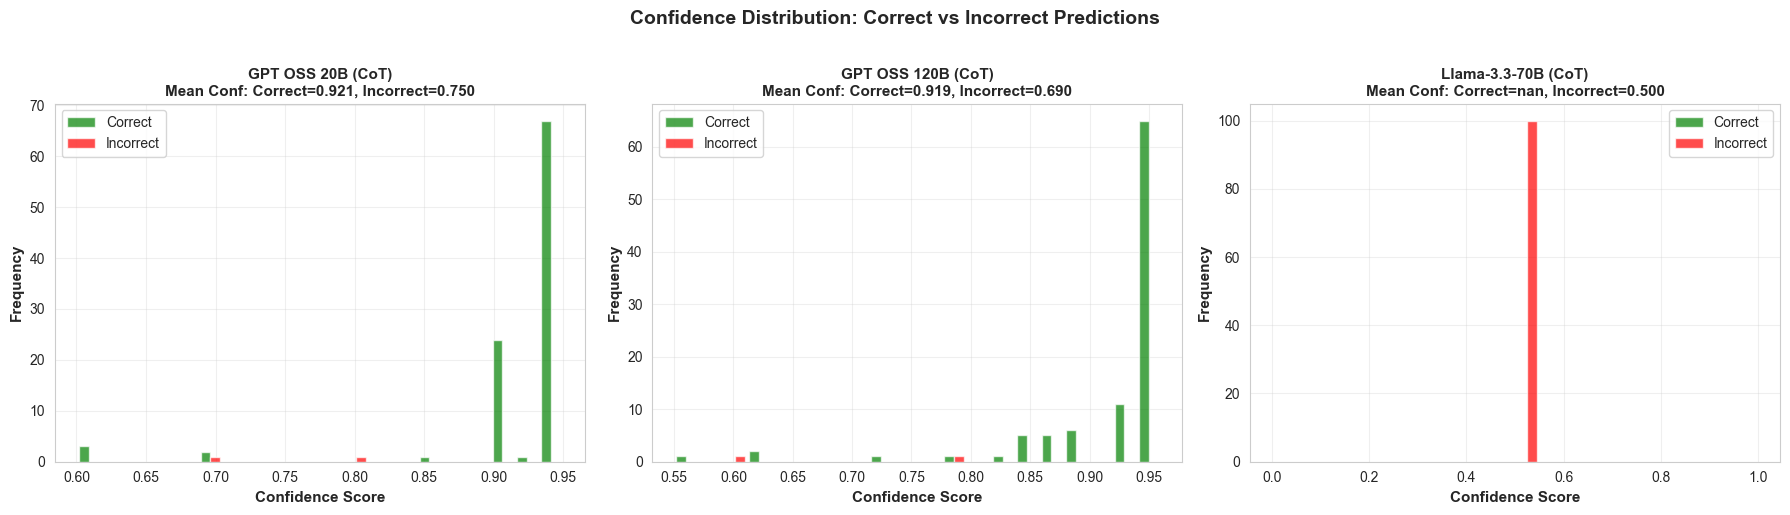

In [13]:
# Confidence analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(e7_valid, "GPT OSS 20B (CoT)"), (e8_valid, "GPT OSS 120B (CoT)"), (e9_valid, "Llama-3.3-70B (CoT)")]
):
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("cot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

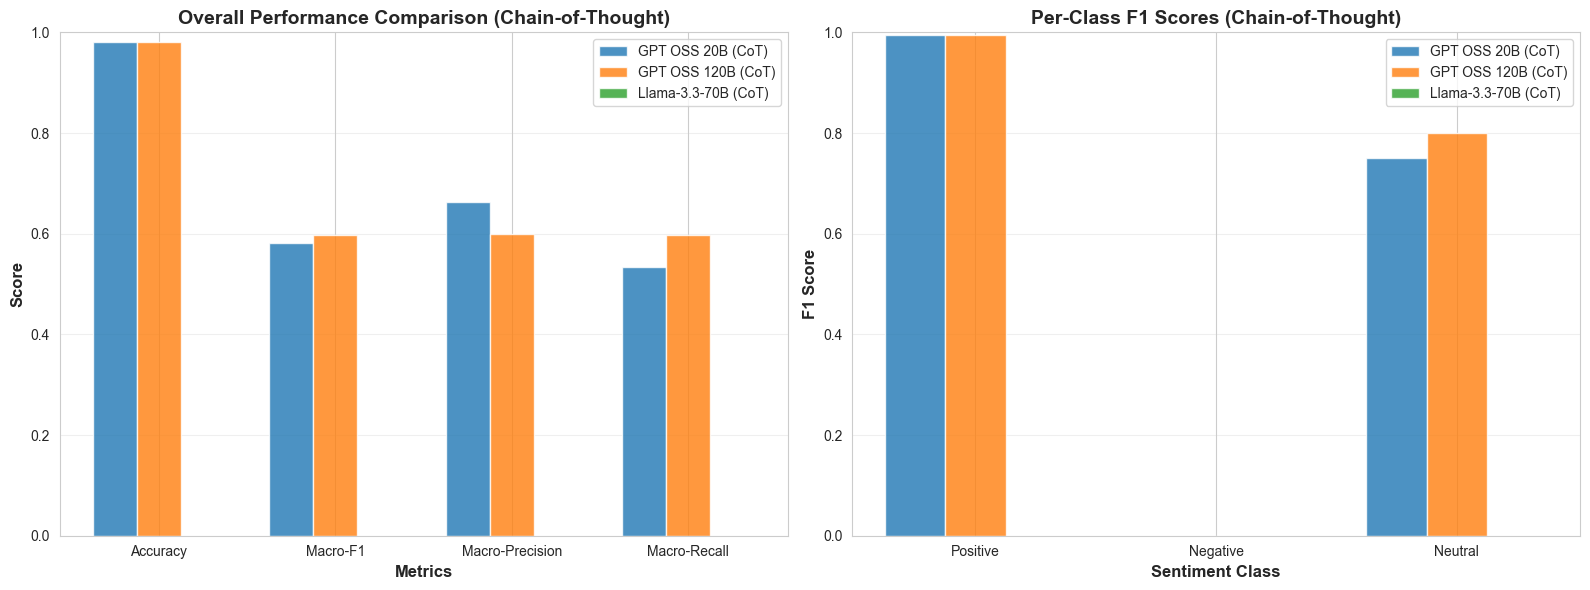

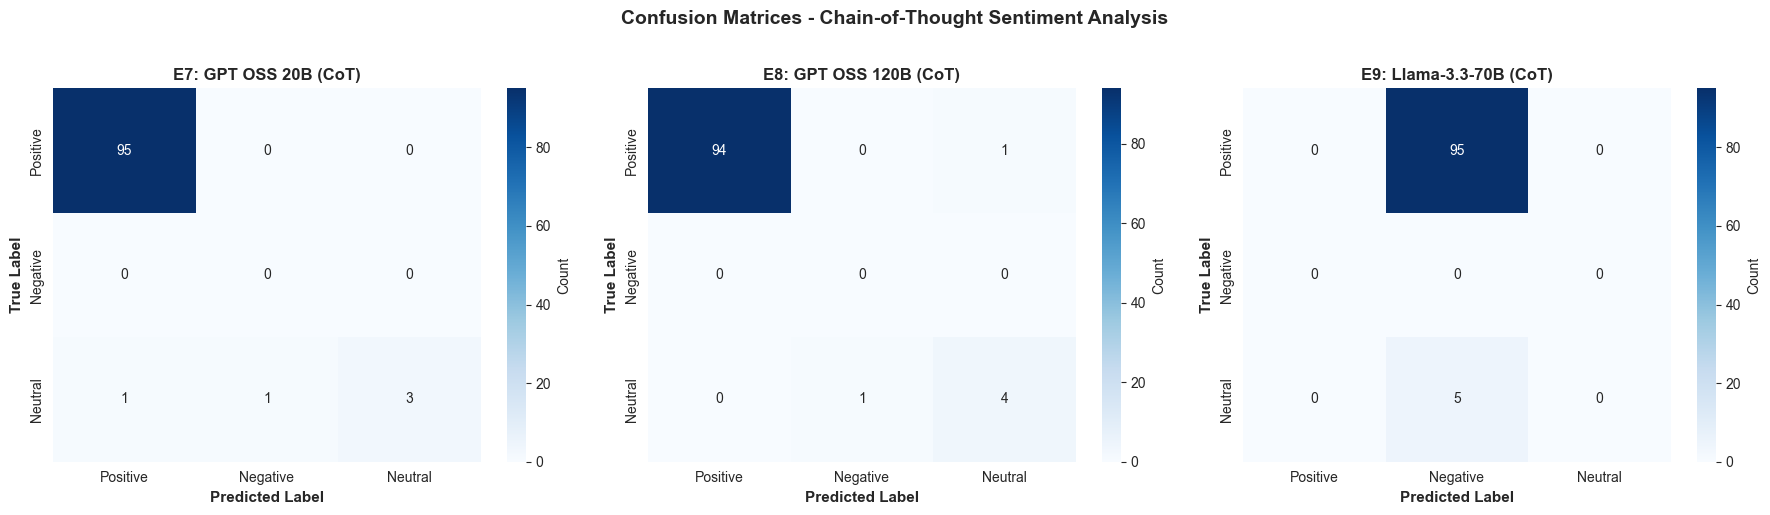

In [14]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (e7_metrics, "GPT OSS 20B (CoT)"),
        (e8_metrics, "GPT OSS 120B (CoT)"),
        (e9_metrics, "Llama-3.3-70B (CoT)"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Chain-of-Thought)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (e7_metrics, "GPT OSS 20B (CoT)"),
        (e8_metrics, "GPT OSS 120B (CoT)"),
        (e9_metrics, "Llama-3.3-70B (CoT)"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Sentiment Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Chain-of-Thought)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("cot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (e7_cm, "E7: GPT OSS 20B (CoT)"),
        (e8_cm, "E8: GPT OSS 120B (CoT)"),
        (e9_cm, "E9: Llama-3.3-70B (CoT)"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Chain-of-Thought Sentiment Analysis",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("cot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Save Results

In [15]:
# Save detailed results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

e7_df.to_csv(f"e7_GPT_OSS_20B_cot_{timestamp}.csv", index=False)
e8_df.to_csv(f"e8_GPT_OSS_120B_cot_{timestamp}.csv", index=False)
e9_df.to_csv(f"e9_Llama-3.3-70B_cot_{timestamp}.csv", index=False)

# Save metrics summary
metrics_df.to_csv(f"cot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Chain-of-Thought results saved with timestamp: {timestamp}")
print("\nFiles created:")
print(f"  - e7_GPT_OSS_20B_cot_{timestamp}.csv")
print(f"  - e8_GPT_OSS_120B_cot_{timestamp}.csv")
print(f"  - e9_Llama-3.3-70B_cot_{timestamp}.csv")
print(f"  - cot_metrics_summary_{timestamp}.csv")
print(f"  - cot_performance_comparison.png")
print(f"  - cot_confusion_matrices.png")


✓ Chain-of-Thought results saved with timestamp: 20260206_094459

Files created:
  - e7_GPT_OSS_20B_cot_20260206_094459.csv
  - e8_GPT_OSS_120B_cot_20260206_094459.csv
  - e9_Llama-3.3-70B_cot_20260206_094459.csv
  - cot_metrics_summary_20260206_094459.csv
  - cot_performance_comparison.png
  - cot_confusion_matrices.png


## 8. Key Findings

### Summary of Chain-of-Thought Results:

1. **Model Performance Ranking**
   - Compare accuracy and F1 scores across the three models
   - Identify which model performs best in chain-of-thought setting

2. **Class-Specific Performance**
   - Analyze which sentiment class is hardest to classify
   - Check if neutral class causes most confusion

3. **Error Analysis**
   - Review misclassified examples
   - Identify common error patterns

4. **Confidence Calibration**
   - Examine relationship between confidence scores and accuracy
   - Identify overconfident or underconfident predictions